In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from picard import amari_distance
from tqdm import tqdm

from generate_data import generate_data
from multiviewica_dilations_shifts import mvica_ds
from plot_functions import plot_sources_2d, plot_sources_3d, scatter_plot_shifts_or_dilations
from apply_dilations_shifts import apply_dilations_shifts_3d_no_argmin

# parameters

In [88]:
m = 5
p = 3
n = 600
max_shift = 0.05
max_dilation = 1.15
bounds_factor = 1.2
noise_data = 0.01
noise_model = 1  # 1 by default
S1_S2_scale = 0.7  # 1 for first function, 0 for second function, 0.5 (for example) for a mixture of both
n_bins = 10  # should divide n
freq_level = 50
number_of_filters_squarenorm_f = 0
filter_length_squarenorm_f = 3
use_envelop_term = True
number_of_filters_envelop = 1
filter_length_envelop = 10
dilation_scale_per_source = True
W_scale = 15
random_state = 0
n_concat = 5  # should divide n
A_B_init_permica = True
penalization_scale = 1e1
verbose = True
return_all_iterations = True
nb_points_grid_init = 10

In [89]:
rng = np.random.RandomState(random_state)

# generate data

In [90]:
X_list, A_list, dilations, shifts, S_list, S = generate_data(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    n_bins=n_bins,
    freq_level=freq_level,
    S1_S2_scale=S1_S2_scale,
    rng=rng,
    n_concat=n_concat,
)

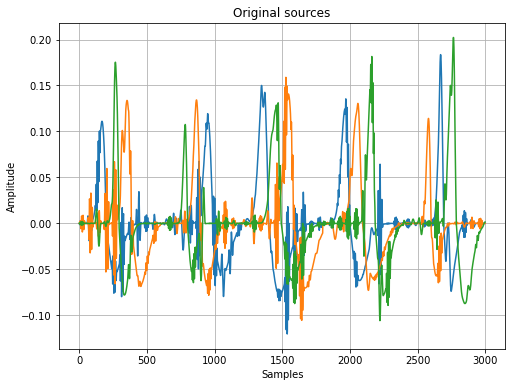

In [91]:
plot_sources_2d(S)

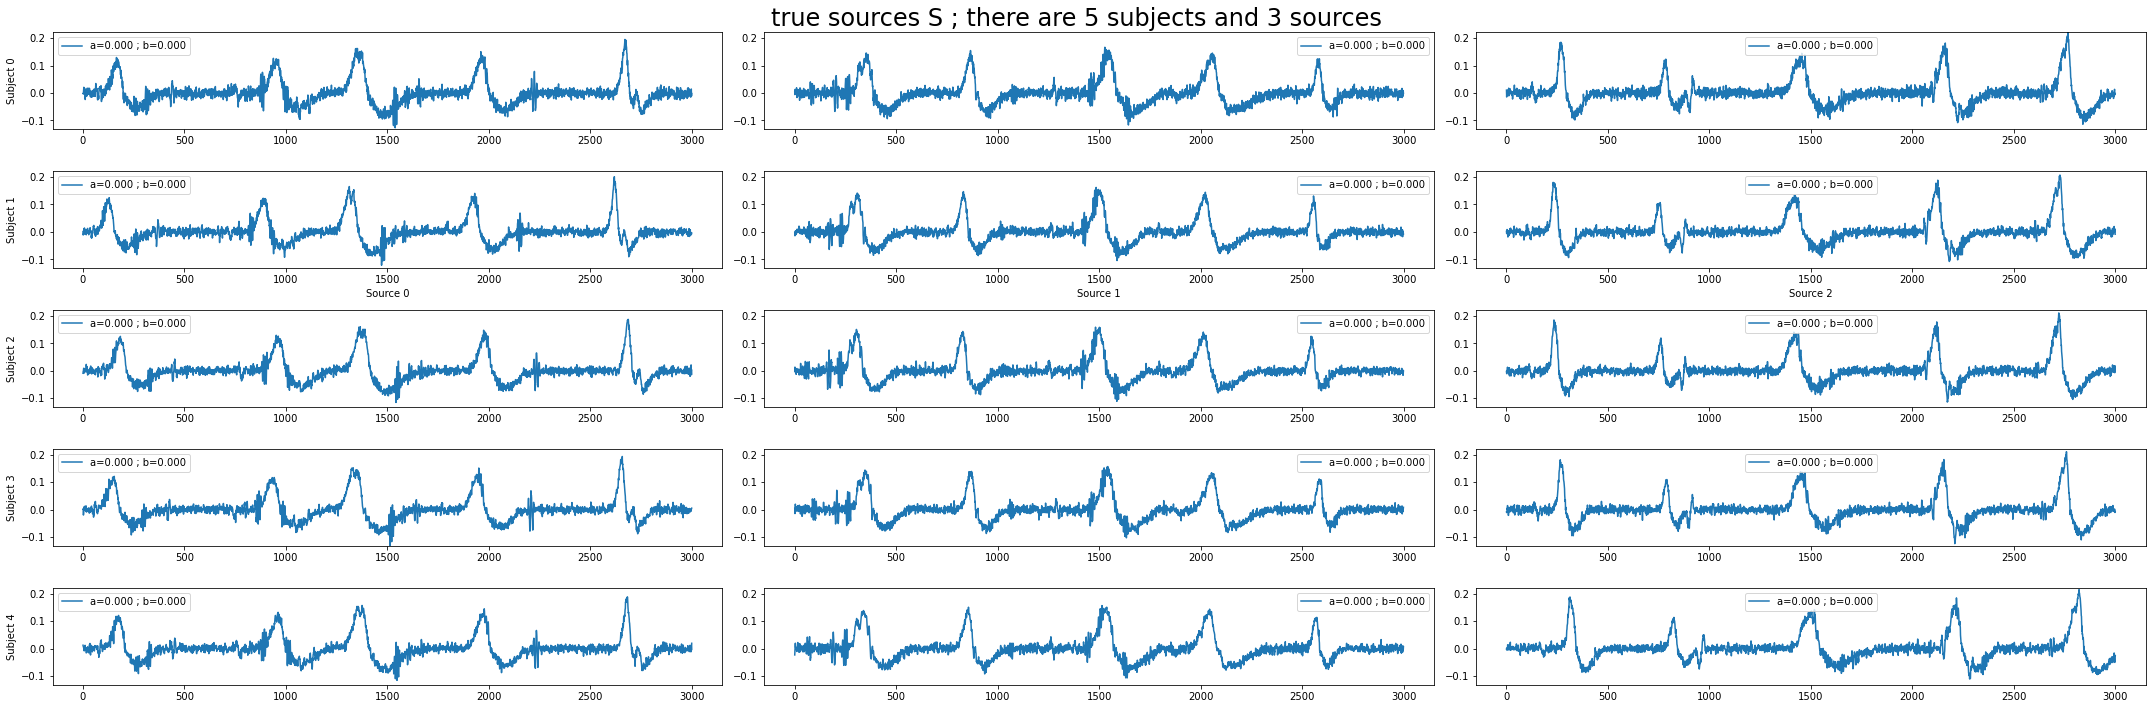

In [92]:
plot_sources_3d(S_list);

# L-BFGS

In [95]:
W_lbfgs, A_lbfgs, B_lbfgs, Y_list_lbfgsb, callback, W_list_init, A_init, B_init = mvica_ds(
    X_list,
    n_concat,
    max_dilation,
    max_shift,
    W_scale,
    dilation_scale_per_source,
    bounds_factor,
    verbose,
    random_state,
    noise_model,
    number_of_filters_envelop,
    filter_length_envelop,
    number_of_filters_squarenorm_f,
    filter_length_squarenorm_f,
    use_envelop_term,
    penalization_scale,
    return_all_iterations,
    nb_points_grid_init,
)


Preprocess permica data...
Preprocessing done.
Jit...
Jit time : 2.7715508937835693
LBFGSB...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42736D+01    |proj g|=  4.90018D+00

At iterate    1    f=  5.39130D+00    |proj g|=  1.81098D+00

At iterate    2    f=  1.21386D+00    |proj g|=  1.25517D+00

At iterate    3    f= -5.44175D+00    |proj g|=  7.37131D-01

At iterate    4    f= -1.15550D+01    |proj g|=  4.55009D-01

At iterate    5    f= -1.83510D+01    |proj g|=  2.71686D-01

At iterate    6    f= -2.49511D+01    |proj g|=  1.63461D-01

At iterate    7    f= -3.11191D+01    |proj g|=  9.86830D-02

At iterate    8    f= -3.64699D+01    |proj g|=  5.35622D-02

At iterate    9    f= -4.00986D+01    |proj g|=  1.06328D-01

At iterate   10    f= -4.16698D+01    |proj g|=  1.76480D-01

At iterate   11    f= -4.33458D+01    |proj g|=  9.0435

# sources order

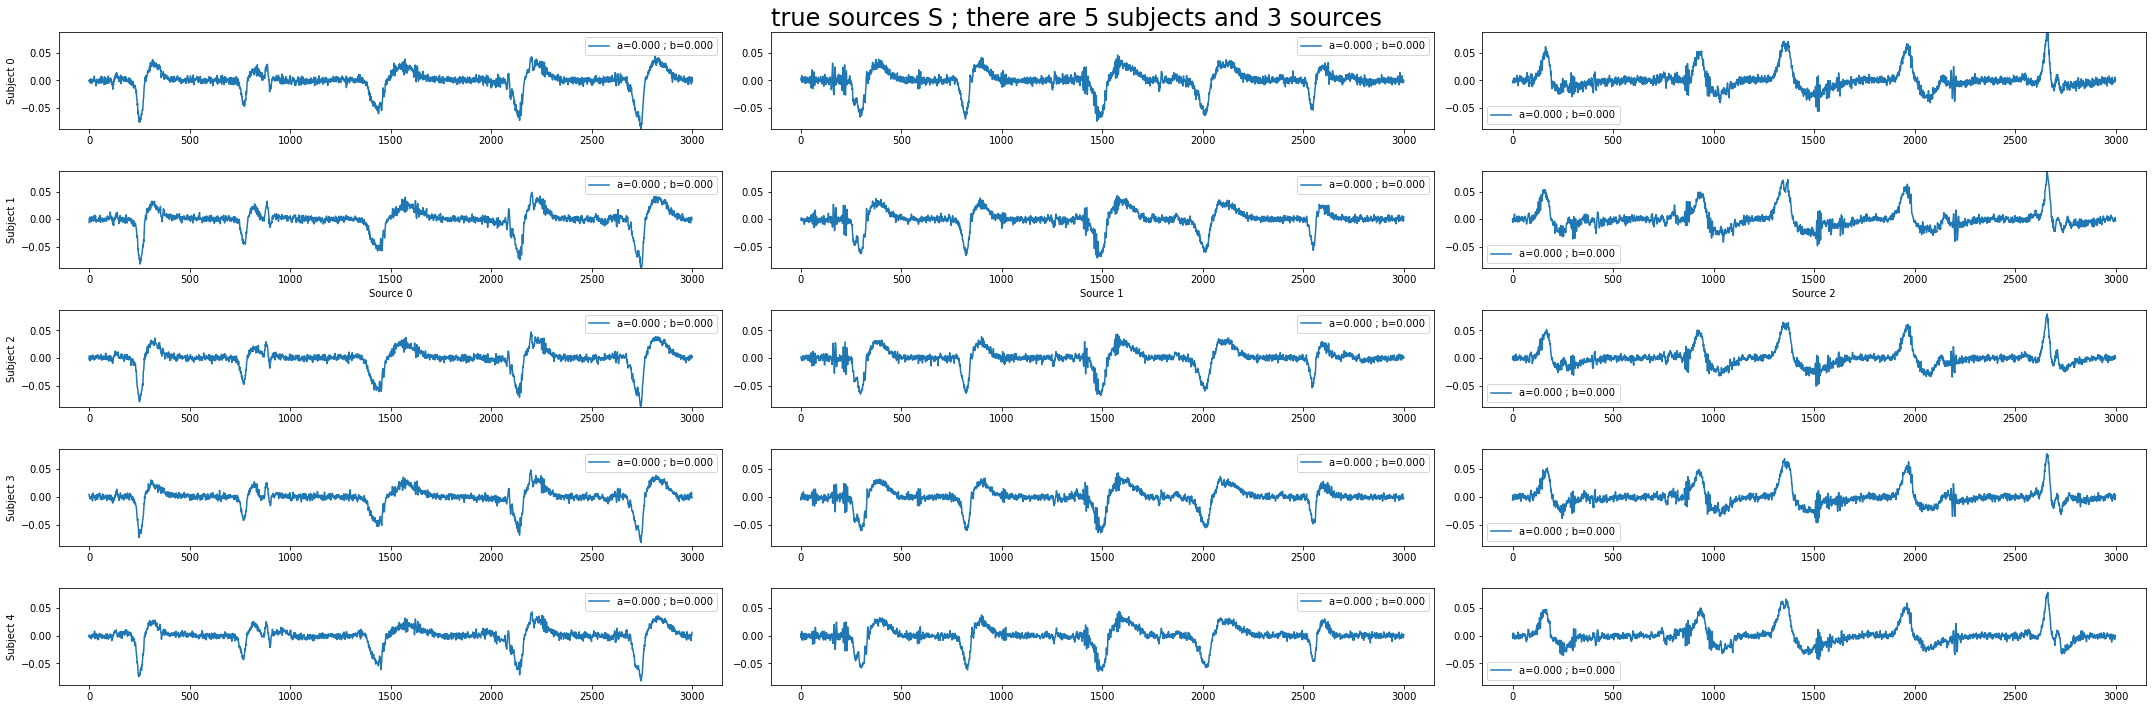

In [82]:
S_list_init = np.array([np.dot(W, X) for W, X in zip(W_list_init, X_list)])
Y_list_init = apply_dilations_shifts_3d_no_argmin(
    S_list_init, A_init, B_init, max_dilation=max_dilation, max_shift=max_shift, shift_before_dilation=False, n_concat=n_concat)
Y_avg_lbfgs = np.mean(Y_list_lbfgsb, axis=0)

# axes = plot_sources_3d(
#     S_list_init, show=False)
# plot_sources_3d(Y_list_init,
#     axes=axes, title="Sources init (blue) and sources after aligning (orange)");
plot_sources_3d(Y_list_init);

In [84]:
A_init

array([[1.        , 1.        , 1.        ],
       [0.93188406, 1.05652174, 1.02536232],
       [0.96304348, 1.08768116, 1.15      ],
       [1.15      , 1.15      , 1.15      ],
       [1.11884058, 1.15      , 1.15      ]])

In [85]:
dilations

array([[1.1245372 , 1.1295446 , 1.04976731],
       [1.01479507, 1.09852373, 1.12295612],
       [0.98039452, 1.05902039, 1.08553271],
       [0.98244817, 0.99796547, 0.92048601],
       [0.90605345, 0.98895386, 0.91244298]])

# scatter plot dilations and shifts

In [47]:
# center time parameters
dilations_c = dilations - np.mean(dilations, axis=0) + 1
shifts_c = shifts - np.mean(shifts, axis=0)
A_lbfgs_c = A_lbfgs - np.mean(A_lbfgs, axis=0) + 1
B_lbfgs_c = B_lbfgs - np.mean(B_lbfgs, axis=0)

# errors
errors_A = np.mean((dilations_c - A_lbfgs_c) ** 2)
errors_B = np.mean((shifts_c - B_lbfgs_c) ** 2)

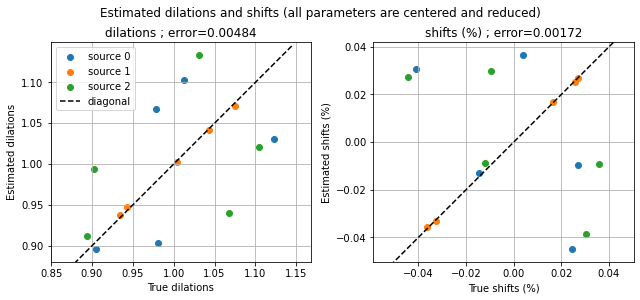

In [48]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

[ax.axis("equal") for ax in axes]
[ax.grid(True) for ax in axes]

scatter_plot_shifts_or_dilations(
    dilations_c,
    A_lbfgs_c,
    errors_A,
    dilations_not_shifts=True,
    legend=True,
    ax=axes[0],
)
scatter_plot_shifts_or_dilations(
    shifts_c,
    B_lbfgs_c,
    errors_B,
    dilations_not_shifts=False,
    legend=False,
    ax=axes[1],
)
fig.suptitle(
    f"Estimated dilations and shifts (all parameters are centered and reduced)",
    y=1.03,
)
# plt.savefig("scatter_plot.pdf", bbox_inches=Bbox([[0, 0], [9, 4.25]]))
plt.show()

# plot Amari distance

In [49]:
amari_init = np.mean([amari_distance(W, A) for W, A in zip(W_list_init, A_list)])
amari_lbfgsb = [amari_init]
for W_list in tqdm(callback.memory_W):
    amari_lbfgsb.append(np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)]))

100%|██████████| 3000/3000 [00:00<00:00, 4501.31it/s]
